In [1]:
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import psutil
from EeSample import EeSample
from EeFault import EeFault
warnings.filterwarnings('ignore') #关闭警告信息
#在notebook中显示动态图像
%matplotlib notebook

In [13]:
class RunApp():
    def __init__(self):
        self.endT = 0.10083
        self.f = 50
        self.fs =1200
        self.N = 24
        self.knum = 5
        self.delatI_set = 2
        self.Zset = np.complex(0.59,4.52)
        return
    
    def sampleProcess(self):
        
        SteadyObj = EeSample(endT=self.endT,f=self.f,fs=self.fs,N=self.N)
        (Stdata,Su_sam,Si_sam) = SteadyObj.sample()

        FaultObj = EeFault(endT=self.endT,f=self.f,fs=self.fs,N=self.N)
        (Ftdata,uFault_sam,iFault_sam) = FaultObj.FaultSam()

        tdata = Stdata
        Usam = Su_sam
        Isam = Si_sam
        Ftdata = np.array(Ftdata)+self.endT

        for index in np.arange(len(Ftdata)):
            tdata.append(Ftdata[index])
            Usam.append(uFault_sam[index])
            Isam.append(iFault_sam[index])
        
        
        return (tdata,np.array(Usam),np.array(Isam))
    
    def deltaEnable(self,tdata,Isam):
        
        markI = 0
        EnableF = False
        for index in np.arange(len(tdata)):
            if index >= self.N:
                deltaI = abs(Isam[index]-Isam[index-self.N])
                #print("前一个周期值index{0}值{1}:".format(index-N,Isam[index-N]))
                #print("当前index{0}值{1}:".format(index,Isam[index]))
                #print(deltaI)
                if deltaI > self.delatI_set:
                    markI += 1
                    if markI >= 3:
                        #print("Falut at {1}s and index is {0} :".format(index,tdata[index]))
                        EnableF = True
                        break
                else:
                    markI = 0
    
        return (EnableF,index)
    
    def plotEe(self,tdata,Isam,startUp,Acting,Iprocess,
               UfnReIm,IfnReIm,FaultImped=np.complex(1,1)):
        
        fig =plt.figure(figsize=(12,16))
        #原始采样电流
        Isam_ax = fig.add_subplot(5,1,1)
        #保护启动信号
        startUp_ax = fig.add_subplot(5,1,2)
        #动作跳闸信号
        Acting_ax = fig.add_subplot(5,1,3)
        #故障电流切除
        Iprocess_ax = fig.add_subplot(5,1,4)
        #电流频率成分
        Ifreq_ax = fig.add_subplot(5,2,9)
        #电压频率成分 
        Ufreq_ax = fig.add_subplot(5,2,10)
        #圆特性距离原件
        fig2 = plt.figure(figsize=(10,5))
        polar_ax = fig2.add_subplot(1,2,1,projection='polar')
        imped_ax = fig2.add_subplot(1,2,2)
        
        
        Isam_ax.grid()
        Isam_ax.plot(tdata,Isam,'r',label="FaultCurrentSample:kA")
        Isam_ax.legend(loc='upper left')
        #Isam_ax.set_autoscaley_on(True)
        #startUp_ax.set_autoscaley_on(True)
        startUp_ax.grid()
        startUp_ax.plot(tdata,startUp,'green',label="StartUpProtection")
        startUp_ax.legend(loc='upper left')
        
        Acting_ax.grid()
        Acting_ax.plot(tdata,Acting,'b',label="ProtectionActing")
        Acting_ax.legend(loc='upper left')
        
        Iprocess_ax.grid()
        Iprocess_ax.plot(tdata,Iprocess,'black',label="FaultCurrent-CutUp:kA")
        Iprocess_ax.legend(loc="upper left")
        
        Ufreq_ax.set_yticks(np.arange(0,40,5))
        Ufreq_ax.bar((np.arange(self.knum))*self.f,np.abs(UfnReIm)/1.414,1.8,color='b',label="FaultVoltageFrequency:kV")
        Ufreq_ax.legend()
        
        Ifreq_ax.set_yticks(np.arange(0,13,1))
        Ifreq_ax.bar((np.arange(self.knum))*self.f,np.abs(IfnReIm)/1.414,1.8,color='b',label="FaultCurrentFrequency;kA")
        Ifreq_ax.legend()
        
        polar_ax.set_thetagrids(np.arange(0.,360.,30.))
        polar_ax.set_rgrids(np.arange(0,5,1.))
        polar_ax.set_rlabel_position(0.)
        polar_ax.set_rlim(0,5)
        polar_ax.set_thetamin(0.)
        polar_ax.set_thetamax(360.)
        polar_ax.grid(True,linestyle="-",color='k',linewidth=0.3,alpha=0.5)
        polar_ax.set_axisbelow('True')
        polar_ax.arrow(0,0,np.angle(self.Zset),np.abs(self.Zset),color='b',linewidth=2.4,label="Zset")
        polar_ax.arrow(0,0,np.angle(FaultImped),np.abs(FaultImped),color='r',linewidth=2.4,label="Zfault")
        
        
        imped_ax.bar(["Zline"],[np.abs(self.Zset)],0.1,color=['g'],label="Zline")
        imped_ax.bar(["Zset1"],[np.abs(self.Zset)*0.8],0.1,color=['b'],label="Zset1")
        imped_ax.bar(["Zfault"],[np.abs(FaultImped)],0.1,color=['r'],label="Zfault")
        imped_ax.set_yticks(np.arange(0,5,0.5))
        imped_ax.legend()
        
        plt.show()
        
        
        return

    def main(self):
        
        (tdata,Usam,Isam) = self.sampleProcess()
        Iprocess = Isam.copy()
        startUp = np.zeros(len(tdata))
        Acting = np.zeros(len(tdata))
        
        #突变量启动
        (FaultEnable,FaultTime) = self.deltaEnable(tdata,Isam)
        startUp[FaultTime:] = 1
        #故障处理 得到基频电压和电流复数形式
        FaultObj = EeFault(endT=self.endT,f=self.f,fs=self.fs,N=self.N)
        #返回故障一周期后计算得到的电压/电流 最大值（实部和虚部）
        (UfnReIm,IfnReIm) = FaultObj.FaultSamReIm(faultSample=(Usam[FaultTime:],Isam[FaultTime:]))  
        #将电压/电流送给距离保护计算 
        (DistancePro_mark,FaultImped) = FaultObj.DistancePro(UfnReIm[1],IfnReIm[1])
        
        if DistancePro_mark == True:
            #模拟故障后一个周期发出跳闸信号
            Acting[FaultTime+self.N-1:] = 1
            #模拟跳闸后故障电流消失
            Iprocess[FaultTime+self.N-1:] = 0

            print("距离保护动作")
        
        self.plotEe(tdata,Isam,startUp,Acting,Iprocess,
                    UfnReIm,IfnReIm,FaultImped)
        

        return (UfnReIm,IfnReIm,FaultImped)


距离保护动作


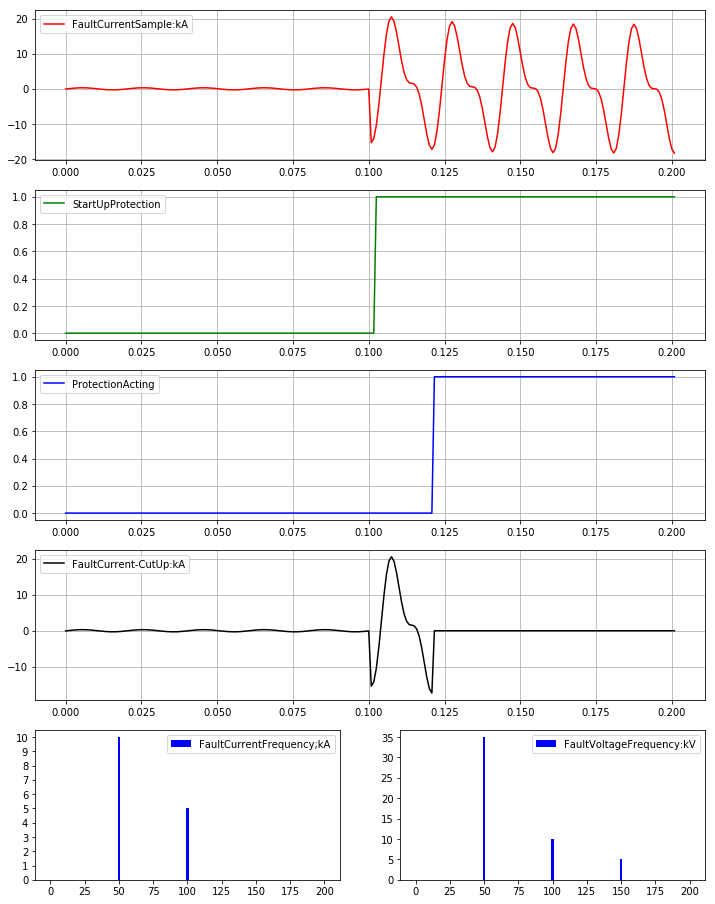

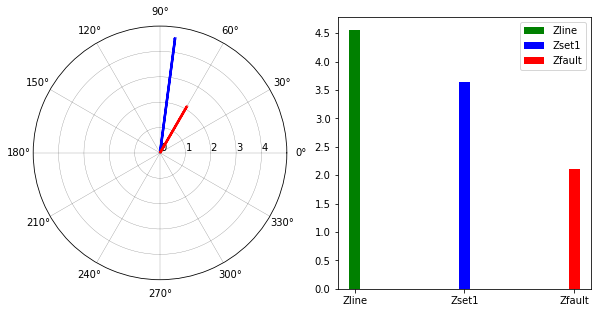

In [14]:
obj = RunApp()
faultData = obj.main()

In [4]:
zset = np.complex(0.59,4.52)

In [15]:
np.abs(faultData[2])

2.1054960444274693